I will not this will be different I am firstly trying out simple generation before I go into the main part of trying to make summerization.

I also used your code for reference when making some of the training, although it will be changed in the final product/ deliverable.

In [ ]:
#imports, bs4 neeeded for the html files
#This one is not the main project just a small draft foused more
#understanding generation

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Tuple, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
#Extracting the stuff I need from html files
#Changed to txt files as html was being troublesome
#html= ["pg72583-images.html", "pg46976-images.html", "pg36922-images.html"]
#txt = ""

In [ ]:
"""
Ok not grabbing the text from file trying something else
for file in html:
  with open(file, 'r', encoding='utf-8') as f:
    html_content = f.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text()
    fullTxt += text
"""

"\nOk not grabbing the text from file trying something else\nfor file in html:\n  with open(file, 'r', encoding='utf-8') as f:\n    html_content = f.read()\n    soup = BeautifulSoup(html_content, 'html.parser')\n    text = soup.get_text()\n    fullTxt += text\n"

In [ ]:
#making a function for looping through the html
"""
Not needed
def getTxt(html):
  txt = ""
  for file in html:
    with open(file, 'r', encoding='utf-8') as f:
      html_content = f.read()
      soup = BeautifulSoup(html_content, 'html.parser')
      text = soup.get_text()
      txt += text
  return txt
"""

'\nNot needed\ndef getTxt(html):\n  txt = ""\n  for file in html:\n    with open(file, \'r\', encoding=\'utf-8\') as f:\n      html_content = f.read()\n      soup = BeautifulSoup(html_content, \'html.parser\')\n      text = soup.get_text()\n      txt += text\n  return txt\n'

In [ ]:
#Cleaning the data
#Removing start and end parts to avoid messy summary
def clean_data(files):
    full_text = ""
    file_list = files
    start_marker_base = "*** START OF"
    end_marker_base = "*** END OF"

    for file_name in file_list:
        if not os.path.exists(file_name):
            print(f"Warning: File not found: {file_name}. Skipping.")
            continue

        try:
            with open(file_name, 'r', encoding='utf-8') as f:
                content = f.read()

            # Find the start of the actual content
            start_index = content.find(start_marker_base)
            if start_index != -1:
                # Find the end of that 'START' line
                start_index = content.find('\n', start_index) + 1
            else:
                print(f"Warning: START marker not found in {file_name}. Using file from beginning.")
                start_index = 0

            # Find the end of the actual content
            end_index = content.find(end_marker_base)
            if end_index == -1:
                print(f"Warning: END marker not found in {file_name}. Using file until end.")
                end_index = len(content)

            # Extract the cleaned text
            cleaned_text = content[start_index:end_index]
            full_text += cleaned_text + "\n" # Add a newline between books

        except Exception as e:
            print(f"Error processing {file_name}: {e}")

    print(f"Text preparation complete. Total characters: {len(full_text)}\n")
    return full_text


In [ ]:
# Making a class for Charater RNN with LSTM layers
# I found this online, the main model will probably use something
# more akin to what we did in class I just wanted to try this out.
#So the main coal of this is that it is the predictor itself
import torch.nn as nn

class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim, n_layers):
        super(CharRNN, self).__init__()
        self.lstm = nn.LSTM(1, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

Model training part

I was hoping to be able to split these into individual notebooks but it seems as if I was not able too, maybe on the final product I will be making one big py notebook.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import math

def train_model(text, n_epochs=5, seq_length=100):

    chars = sorted(list(set(text)))
    char_to_int = {ch: i for i, ch in enumerate(chars)}
    int_to_char = {i: ch for i, ch in enumerate(chars)}
    n_vocab = len(chars)
    print(f"Vocabulary size: {n_vocab} unique characters.")

    dataX, dataY = [], []
    for i in range(0, len(text) - seq_length, 1):
        seq_in = text[i:i + seq_length]
        seq_out = text[i + seq_length]
        dataX.append([char_to_int[char] for char in seq_in])
        dataY.append(char_to_int[seq_out])

    #This should create the dataset
    full_dataset = TensorDataset(
        torch.tensor(dataX, dtype=torch.float32).reshape(len(dataX), seq_length, 1) / float(n_vocab),
        torch.tensor(dataY, dtype=torch.int64)
    )

    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    print(f"{len(train_dataset)} training samples, {len(val_dataset)} validation samples.\n")

    model = CharRNN(n_vocab, 256, 2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #took this portion from AI
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # to here, this will help run faster if gpu is found on device


    for epoch in range(n_epochs):

        model.train()
        total_loss = 0.0 #This will total the loss
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad() # Gets rid of old calculation
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)


        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                output = model(inputs)
                loss = criterion(output, targets)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)

        perplexity = math.exp(avg_val_loss)

        print(f"Epoch: {epoch+1}/{n_epochs}")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Test/Validation Loss: {avg_val_loss:.4f}")
        print(f"Test/Validation Perplexity: {perplexity:.2f}")


    return model, char_to_int, int_to_char, n_vocab

In [ ]:
def generate_text(model, char_maps, vocab_size, start_string="the world was", length=400):
    char_to_int, int_to_char = char_maps
    model.eval()
    device = next(model.parameters()).device

    pattern = [char_to_int[char] for char in start_string.lower() if char in char_to_int]
    result = list(start_string)

    with torch.no_grad():
        for _ in range(length):
            x = torch.tensor(pattern, dtype=torch.float32).reshape(1, len(pattern), 1) / float(vocab_size)
            x = x.to(device)

            prediction = model(x)

            index = torch.argmax(prediction).item()
            result.append(int_to_char[index])

            pattern.append(index)
            pattern = pattern[1:]

    return "".join(result)

In [ ]:
def token_frequency(text, top_n=30):

    # 1. Process text into words (filtering spaces and single letters)
    words = text.split()
    filtered_words = [w for w in words if len(w) > 1]

    # 2. Count occurrences
    counts = Counter(filtered_words)

    common_tokens = counts.most_common(top_n)
    if not common_tokens:
        print("No text")
        return

    tokens, frequencies = zip(*common_tokens)


    sns.set_theme(style="dark")

    plt.figure(figsize=(12, 6))

    # Create the barplot
    plot = sns.barplot(x=list(tokens), y=list(frequencies), palette="viridis", hue=list(tokens), legend=False) # CHANGED: Plotting words

    plt.xlabel('Token', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(f'Top {top_n} Words in text (Length > 1)', fontsize=14)
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()
    print("Visualization generated.")

Text preparation complete. Total characters: 2293766

Vocabulary size: 279 unique characters.
2064299 training samples, 229367 validation samples.

Epoch: 1/5
Training Loss: 2.5851
Test/Validation Loss: 2.2243
Test/Validation Perplexity: 9.25
Epoch: 2/5
Training Loss: 2.0990
Test/Validation Loss: 1.9817
Test/Validation Perplexity: 7.25
Epoch: 3/5
Training Loss: 1.9086
Test/Validation Loss: 1.8467
Test/Validation Perplexity: 6.34
Epoch: 4/5
Training Loss: 1.7929
Test/Validation Loss: 1.7602
Test/Validation Perplexity: 5.81
Epoch: 5/5
Training Loss: 1.7113
Test/Validation Loss: 1.7173
Test/Validation Perplexity: 5.57
==================== CREATIVE GENERATED TEXT ====================
it was a time of great change, and the people of the season of the season hs the season of the srbnecr of the season of the season and the same time in the season of the season of the season and the cone of the season and the cone of the season and the cone of the season and the cone of the season and the cone

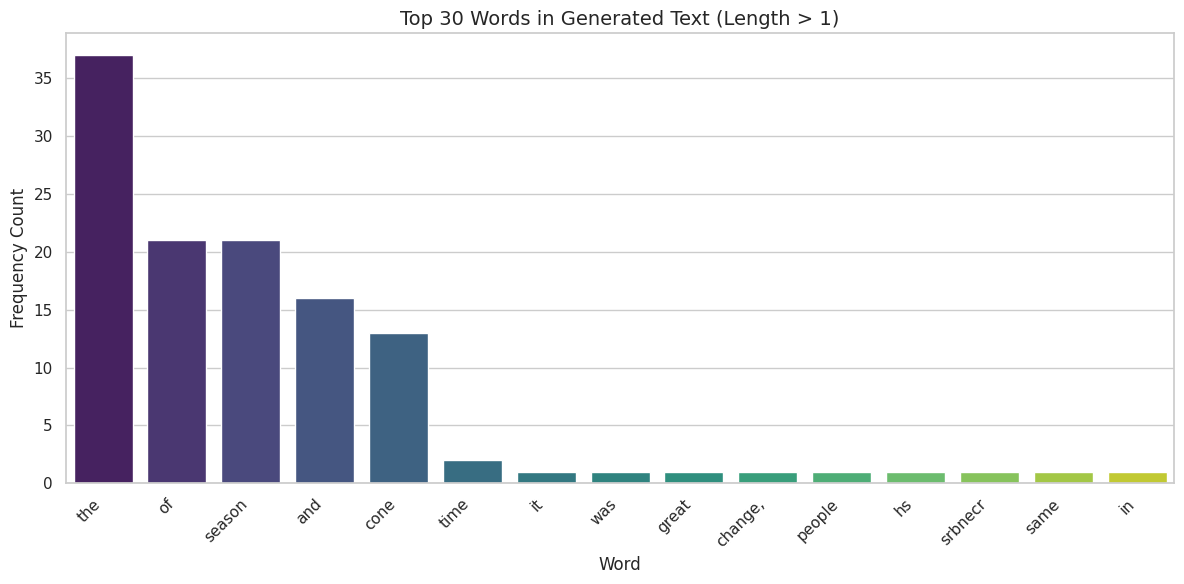

Visualization generated.


In [ ]:
 import seaborn as sns # Import seaborn for plotting

#I did use AI to help build this as I was lost.
#It still does not work but I will try to understand why
# The error was due to a shape mismatch between the model output and the target in the loss function.
# The fix involves reshaping the output and target tensors before calculating the loss.
if __name__ == "__main__":
    FILE_LIST = [
        "The Genuine Works of Hippocrates vol 1(of 2) _ Project Gutenberg.txt",
        "The Project Gutenberg eBook of Anabasis of Alexander, by Arrian.txt",
        "Antarctic Penguins, by George Murray Levick—A Project Gutenberg eBook.txt"
    ]
    EPOCHS_TO_TRAIN = 5
    SEED_TEXT = "it was a time of great change, and the people"
    seq_length = 100 # Define seq_length here

    # --- Run the pipeline ---
    corpus_text = clean_data(FILE_LIST)

    if corpus_text and len(corpus_text) > (seq_length * 10): # Ensure there's enough text
        # Train and evaluate the model
        trained_model, cti, itc, n_v = train_model(corpus_text, n_epochs=EPOCHS_TO_TRAIN, seq_length=seq_length)

        # Generate text
        maps = (cti, itc)
        creative_text = generate_text(trained_model, maps, n_v, start_string=SEED_TEXT, length=500)

        # Print the final result
        print("="*20 + " CREATIVE GENERATED TEXT " + "="*20)
        print(creative_text)
        print("\n" + "="*61 + "\n")

        # visualizted
        token_frequency(creative_text)

    elif not corpus_text:
        print("Error: No text was loaded from the files. Please check file paths and markers.")
    else:
        print(f"Error: The loaded text is too short (less than {seq_length * 10} chars).")